In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random

tfk  = tf.keras
tfkl = tf.keras.layers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Random seed for reproducibility
seed = 69

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
df = pd.read_csv('../input/dataset1/dataset.csv')
df.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


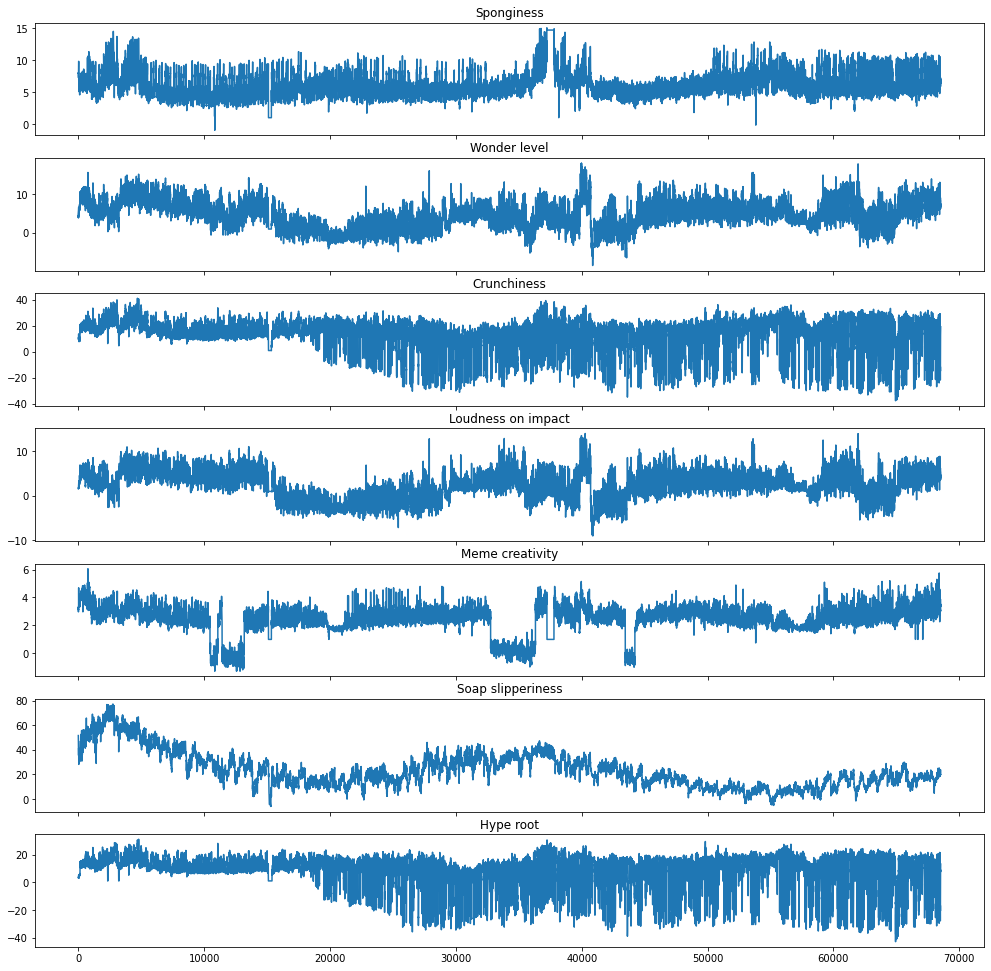

In [4]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(df, df.columns)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sponginess,68528.0,6.094102,1.941639,-0.972080,4.79144,5.702780,7.067300,15.106680
Wonder level,68528.0,4.695539,3.374224,-8.450380,2.22342,4.668600,7.115440,18.122899
Crunchiness,68528.0,13.337485,11.703203,-37.581721,10.67282,15.676059,20.568080,41.138801
Loudness on impact,68528.0,2.448660,3.001798,-9.028060,0.46880,2.533840,4.656980,14.035980
Meme creativity,68528.0,2.407010,0.994063,-1.275860,2.11220,2.618500,3.021880,6.056360
Soap slipperiness,68528.0,23.237929,14.298260,-6.006860,12.56024,20.151420,31.245199,77.371620
Hype root,68528.0,8.231283,11.285101,-42.769221,6.60416,10.968300,15.334100,31.024420


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.70)]
val_df = df[int(n*0.70):int(n*0.85)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]

In [7]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

In [8]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model=None, plot_col='Sponginess', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
    
        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index],
                label='Labels', c='#2ca02c')
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index],
                          label='Predictions', c='#ff7f0e')

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=10,
          shuffle=True,
          batch_size=32)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
        
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

2021-12-26 02:18:57.035041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 02:18:57.124242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 02:18:57.125029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 02:18:57.127305: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

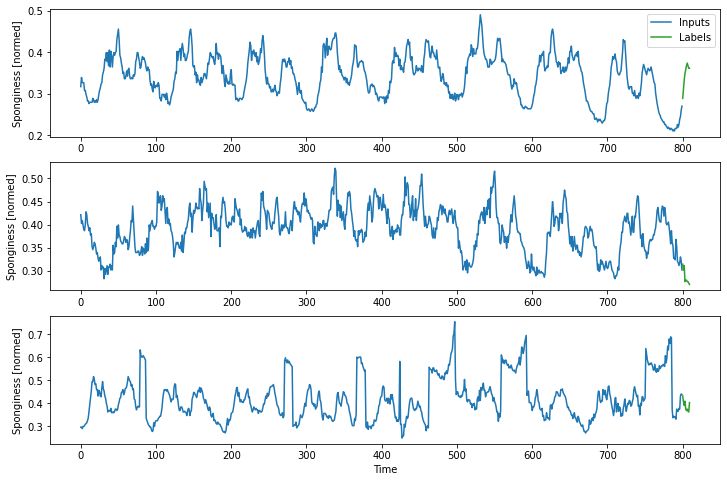

In [13]:
OUT_STEPS = 10
INPUT_WIDTH = 800
STRIDE = 10
input_shape = (INPUT_WIDTH, num_features)

multi_step_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_step_window.plot()

In [14]:
class Time2Vector(tfkl.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [15]:
def transformer_encoder(input_layer, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(input_layer, input_layer)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + input_layer

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=input_layer.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [16]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    time_embedding = Time2Vector(input_shape[0])
    input_layer = tfk.Input(shape=input_shape)
    x = input_layer
#     x = time_embedding(input_layer)
#     x = tfkl.Concatenate(axis=-1)([input_layer, x])
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
        
    x = tfkl.Dense(OUT_STEPS*num_features)(x)
    #Shape => [batch, out_steps, features].
    output_layer = tfkl.Reshape([OUT_STEPS, num_features])(x)
    
    # Connect input and output through the Model class
    multi_lstm_model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'multi_lstm_model')
    
    multi_lstm_model.compile(loss=tfk.losses.MeanSquaredError(), 
              optimizer=tfk.optimizers.Adam(learning_rate = 1e-3), 
              metrics=[tfk.metrics.RootMeanSquaredError()])
    
    return multi_lstm_model

In [17]:
def lr_scheduler(epoch, lr, warmup_epochs=10, decay_epochs=50, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [18]:
epochs   = 200
patience = 10

multi_lstm_model = build_model(input_shape, head_size=128, num_heads=12, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25)

multi_lstm_model.summary()

history = multi_lstm_model.fit(multi_step_window.train,
                    epochs=epochs,
                    validation_data=multi_step_window.val,
                    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                               tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
#                                tfk.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
                               ])

# Save best epoch model
multi_lstm_model.save("best_model/")

# !pip install gdown
# !gdown --id 1BHcWaG5mYCGqxw_rG7slAXVrLFWjDvuo
# !unzip best_model.zip

# multi_lstm_model = tfk.models.load_model('./best_model')

val_performance = multi_lstm_model.evaluate(multi_step_window.val)
performance     = multi_lstm_model.evaluate(multi_step_window.test, verbose=0)

Model: "multi_lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 7)]     0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 800, 7)       47623       input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 7)       0           multi_head_attention[0][0]       
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 800, 7)       14          dropout[0][0]     

2021-12-26 02:19:05.686327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


148/148 [==============================] - 98s 596ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 2/200
148/148 [==============================] - 88s 594ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 3/200
148/148 [==============================] - 88s 594ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 4/200
148/148 [==============================] - 88s 593ms/step - loss: 0.0231 - root_mean_squared_error: 0.1519 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 5/200
148/148 [==============================] - 88s 594ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 6/200
148/148 [==============================] - 88s 594ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0

2021-12-26 03:15:38.949904: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


30/30 [==============================] - 5s 175ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260


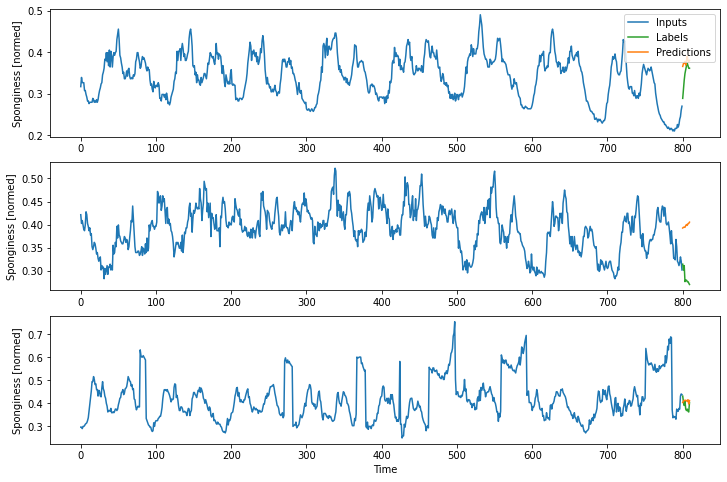

In [19]:
multi_step_window.plot(multi_lstm_model)

In [20]:
predictions = multi_lstm_model.predict(multi_step_window.test)
print(predictions.shape)

(948, 10, 7)


In [21]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=STRIDE, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [22]:
target_labels = df.columns 
X_train_raw = df.iloc[0:int(n*0.70)]
X_test_raw = df.iloc[int(n*0.85):]

train_minimum = X_train_raw.min()
train_maximum = X_train_raw.max()

X_train_raw = (X_train_raw - train_minimum) / (train_maximum - train_minimum)
X_test_raw = (X_test_raw - train_minimum) / (train_maximum - train_minimum)

In [23]:
reg_telescope = INPUT_WIDTH + num_features * OUT_STEPS
reg_telescope = 870
X_train, y_train = build_sequences(X_train_raw, target_labels, INPUT_WIDTH, STRIDE, OUT_STEPS)
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, INPUT_WIDTH, STRIDE, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((873, 800, 7), (873, 870, 7))

In [24]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,OUT_STEPS):
    pred_temp = multi_lstm_model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,OUT_STEPS:,:],pred_temp), axis=1)
    print(reg_predictions.shape)

(873, 10, 7)
(873, 20, 7)
(873, 30, 7)
(873, 40, 7)
(873, 50, 7)
(873, 60, 7)
(873, 70, 7)
(873, 80, 7)
(873, 90, 7)
(873, 100, 7)
(873, 110, 7)
(873, 120, 7)
(873, 130, 7)
(873, 140, 7)
(873, 150, 7)
(873, 160, 7)
(873, 170, 7)
(873, 180, 7)
(873, 190, 7)
(873, 200, 7)
(873, 210, 7)
(873, 220, 7)
(873, 230, 7)
(873, 240, 7)
(873, 250, 7)
(873, 260, 7)
(873, 270, 7)
(873, 280, 7)
(873, 290, 7)
(873, 300, 7)
(873, 310, 7)
(873, 320, 7)
(873, 330, 7)
(873, 340, 7)
(873, 350, 7)
(873, 360, 7)
(873, 370, 7)
(873, 380, 7)
(873, 390, 7)
(873, 400, 7)
(873, 410, 7)
(873, 420, 7)
(873, 430, 7)
(873, 440, 7)
(873, 450, 7)
(873, 460, 7)
(873, 470, 7)
(873, 480, 7)
(873, 490, 7)
(873, 500, 7)
(873, 510, 7)
(873, 520, 7)
(873, 530, 7)
(873, 540, 7)
(873, 550, 7)
(873, 560, 7)
(873, 570, 7)
(873, 580, 7)
(873, 590, 7)
(873, 600, 7)
(873, 610, 7)
(873, 620, 7)
(873, 630, 7)
(873, 640, 7)
(873, 650, 7)
(873, 660, 7)
(873, 670, 7)
(873, 680, 7)
(873, 690, 7)
(873, 700, 7)
(873, 710, 7)
(873, 720, 7)
(

In [25]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.015796278>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.098269664>)

In [26]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

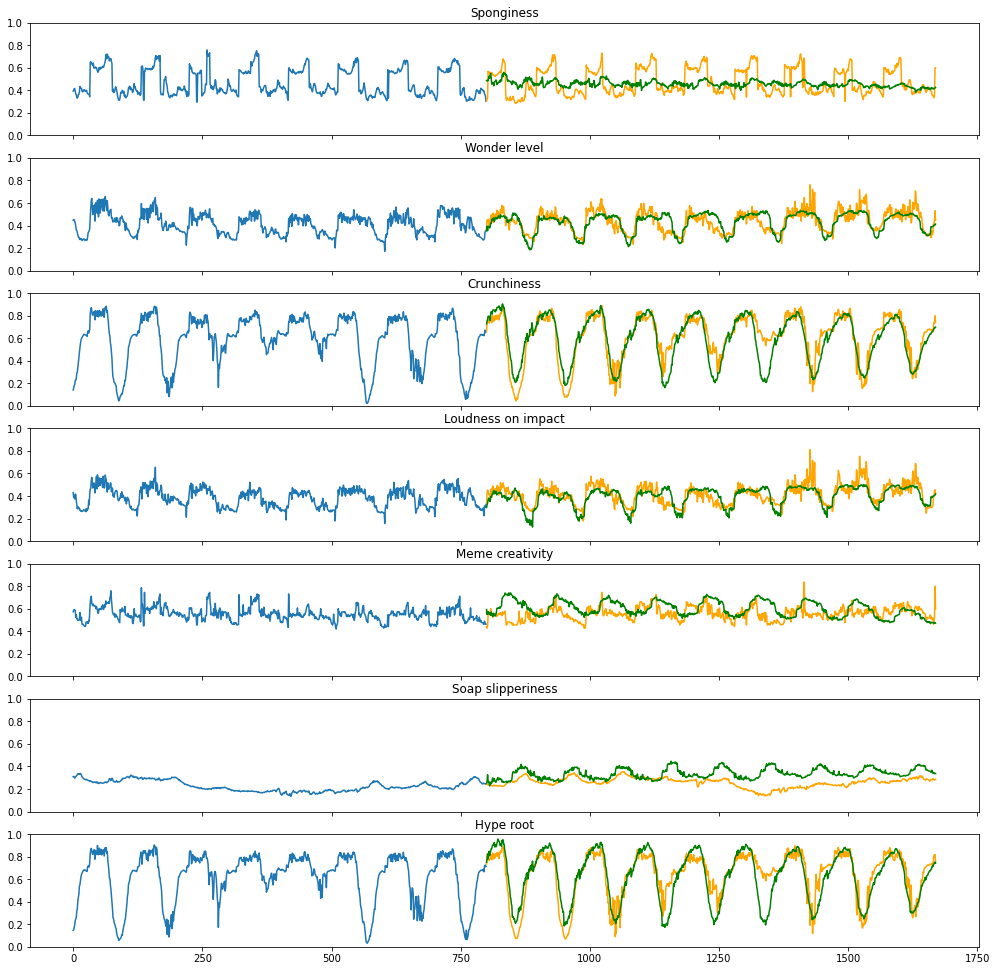

In [27]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

In [28]:
future = df[-INPUT_WIDTH:]
future = (future-train_minimum)/(train_maximum-train_minimum)
future = np.expand_dims(future, axis=0)
future.shape

(1, 800, 7)

In [29]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [30]:
reg_future = np.array([])
X_temp = future
for reg in range(0,reg_telescope,OUT_STEPS):
    pred_temp = multi_lstm_model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,OUT_STEPS:,:],pred_temp), axis=1)
    print(reg_future.shape)

(1, 10, 7)
(1, 20, 7)
(1, 30, 7)
(1, 40, 7)
(1, 50, 7)
(1, 60, 7)
(1, 70, 7)
(1, 80, 7)
(1, 90, 7)
(1, 100, 7)
(1, 110, 7)
(1, 120, 7)
(1, 130, 7)
(1, 140, 7)
(1, 150, 7)
(1, 160, 7)
(1, 170, 7)
(1, 180, 7)
(1, 190, 7)
(1, 200, 7)
(1, 210, 7)
(1, 220, 7)
(1, 230, 7)
(1, 240, 7)
(1, 250, 7)
(1, 260, 7)
(1, 270, 7)
(1, 280, 7)
(1, 290, 7)
(1, 300, 7)
(1, 310, 7)
(1, 320, 7)
(1, 330, 7)
(1, 340, 7)
(1, 350, 7)
(1, 360, 7)
(1, 370, 7)
(1, 380, 7)
(1, 390, 7)
(1, 400, 7)
(1, 410, 7)
(1, 420, 7)
(1, 430, 7)
(1, 440, 7)
(1, 450, 7)
(1, 460, 7)
(1, 470, 7)
(1, 480, 7)
(1, 490, 7)
(1, 500, 7)
(1, 510, 7)
(1, 520, 7)
(1, 530, 7)
(1, 540, 7)
(1, 550, 7)
(1, 560, 7)
(1, 570, 7)
(1, 580, 7)
(1, 590, 7)
(1, 600, 7)
(1, 610, 7)
(1, 620, 7)
(1, 630, 7)
(1, 640, 7)
(1, 650, 7)
(1, 660, 7)
(1, 670, 7)
(1, 680, 7)
(1, 690, 7)
(1, 700, 7)
(1, 710, 7)
(1, 720, 7)
(1, 730, 7)
(1, 740, 7)
(1, 750, 7)
(1, 760, 7)
(1, 770, 7)
(1, 780, 7)
(1, 790, 7)
(1, 800, 7)
(1, 810, 7)
(1, 820, 7)
(1, 830, 7)
(1, 840, 7)
(

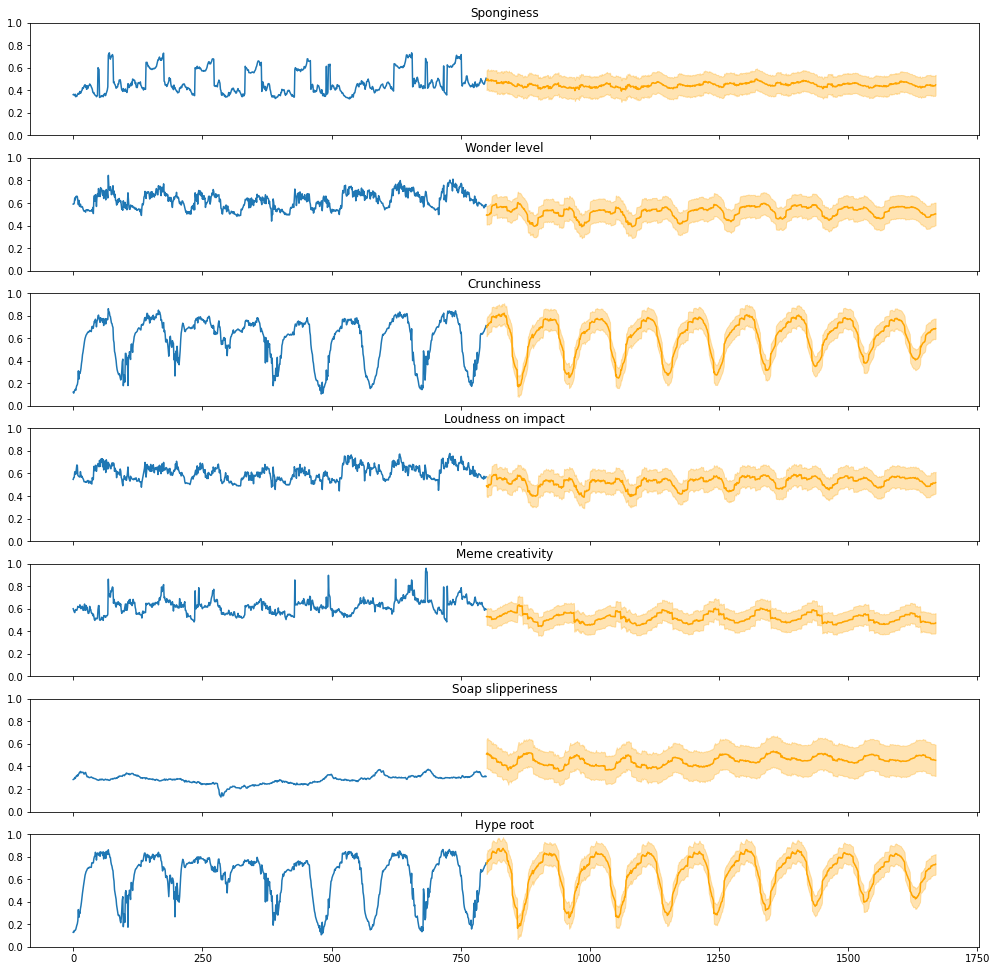

In [31]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

In [32]:
# Insert your preprocessing here

# X = np.array(pd.read_csv('../input/dataset1/dataset.csv'))

# X_min = X.min(axis=0)
# X_max = X.max(axis=0)
# X_min, X_max

# print(X)
# print("mean", X.mean(axis=0))
# print("std", X.std(axis=0))
# print("=================")

# window = 800
# future = X[-window:]
# future = (future - X_min) / (X_max - X_min)
# future = np.expand_dims(future, axis=0)

# OUT_STEPS = 10
# reg_telescope = window + 7 * OUT_STEPS

# reg_future = np.array([])
# X_temp = future

# for reg in range(0,reg_telescope,OUT_STEPS):
#     pred_temp = multi_lstm_model.predict(X_temp)
#     if(len(reg_future)==0):
#         reg_future = pred_temp
#     else:
#         reg_future = np.concatenate((reg_future,pred_temp),axis=1)
#     X_temp = np.concatenate((X_temp[:,OUT_STEPS:,:],pred_temp), axis=1)

# out = reg_future

# # Insert your postprocessing here
# out = out * (X_max - X_min) + X_min
# out = np.reshape(out, (870, 7))
# out = out[:864, :]

# print(out)
# print("mean", out.mean(axis=0))
# print("std", out.std(axis=0))

# if np.isnan(out).any():
#     out = 0
#     print('Nan prediction')

# plt.plot(out)
# plt.show()

# out = tf.convert_to_tensor(out)

In [33]:
!zip -r attention_w800_s10_o10_h12_128.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/best_model/ (stored 0%)
  adding: kaggle/working/best_model/variables/ (stored 0%)
  adding: kaggle/working/best_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/best_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/best_model/assets/ (stored 0%)
  adding: kaggle/working/best_model/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/best_model/saved_model.pb (deflated 91%)
  adding: kaggle/working/__notebook__.ipynb (deflated 70%)
